In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
import optuna

# 데이터 로드

In [2]:
data_path = '../data/'

train_df = pd.read_csv(data_path+'train.csv', index_col='id')
test_df = pd.read_csv(data_path+'test.csv', index_col='id')
submission_df = pd.read_csv(data_path+'sample_submission.csv', index_col='id')

# 전처리

## EDA

In [3]:
def resume_table(df):
    print(f'df.shape: {df.shape}')
    summary_df = pd.DataFrame(df.dtypes)
    df = df * 1 # defects를 int형으로 바꾸기
    summary_df.index.name = 'Column'
    summary_df.columns = ['Dtypes']
    summary_df['결측치'] = df.isnull().sum().values
    summary_df['유니크개수'] = df.nunique().values
    temp_df = df[:5].T
    temp_df.index.name = 'Column'
    summary_df = summary_df.merge(temp_df, on='Column')
    return summary_df.merge(df.describe().T[['mean', 'min', '50%', 'max']], on='Column')
    
resume_table(train_df)

df.shape: (101763, 22)


,Dtypes,결측치,유니크개수,0,1,2,3,4,mean,min,50%,max
Column,,,,,,,,,,,,
loc,float64,0,378,22.00,14.00,11.00,8.00,11.00,37.347160,1.0,22.00,3442.00
v(g),float64,0,106,3.00,2.00,2.00,1.00,2.00,5.492684,1.0,3.00,404.00
ev(g),float64,0,71,1.00,1.00,1.00,1.00,1.00,2.845022,1.0,1.00,165.00
iv(g),float64,0,84,2.00,2.00,2.00,1.00,2.00,3.498826,1.0,2.00,402.00
n,float64,0,836,60.00,32.00,45.00,23.00,17.00,96.655995,0.0,51.00,8441.00
v,float64,0,4515,278.63,151.27,197.65,94.01,60.94,538.280956,0.0,232.79,80843.08
l,float64,0,55,0.06,0.14,0.11,0.19,0.18,0.111634,0.0,0.09,1.00
d,float64,0,3360,19.56,7.00,8.05,5.25,5.63,13.681881,0.0,9.82,418.20
i,float64,0,5171,14.25,21.11,22.76,17.86,12.44,27.573007,0.0,23.36,569.78


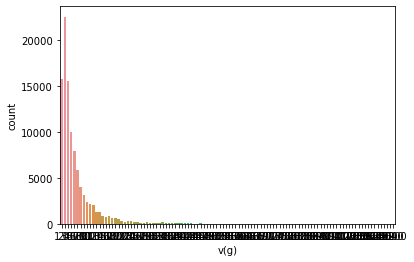

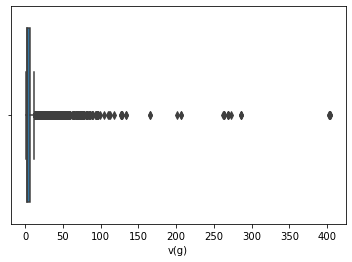

In [4]:
sns.countplot(train_df, x='v(g)')
plt.show()
sns.boxplot(train_df, x='v(g)')
plt.show()

In [5]:
train_df['defects'].value_counts()

False    78699
True     23064
Name: defects, dtype: int64

In [6]:
# 정수인지 실수인지 확인
(train_df['loc'] % 1).value_counts()

0.0    101763
Name: loc, dtype: int64

In [7]:
# float --> int
train_df['loc'] = train_df['loc'].astype('int')
train_df['v(g)'] = train_df['v(g)'].astype('int')
train_df['ev(g)'] = train_df['ev(g)'].astype('int')
train_df['iv(g)'] = train_df['iv(g)'].astype('int')
train_df['n'] = train_df['n'].astype('int')

train_df['uniq_Op'] = train_df['uniq_Op'].astype('int')
train_df['uniq_Opnd'] = train_df['uniq_Opnd'].astype('int')
train_df['total_Op'] = train_df['total_Op'].astype('int')
train_df['total_Opnd'] = train_df['total_Opnd'].astype('int')
train_df['branchCount'] = train_df['branchCount'].astype('int')

https://www.kaggle.com/competitions/playground-series-s3e23/discussion/445196 참고

## McCabe's

1. loc             :McCabe's line count of code
2. v(g)            :McCabe "cyclomatic complexity"
3. ev(g)           :McCabe "essential complexity"
4. iv(g)           : McCabe "design complexity"

## Halstead's

****Derived measures****

5. n               : Halstead  “length” = N1+N2
6. v               : Halstead "volume" = n*log2(mu1+mu2))
7. l               : Halstead "program length" = mu1 *log2(mu1)+mu2* log2(mu2)
8. d               : Halstead "difficulty" = (mu1/2)*(N2/mu2)
9. i               : Halstead "intelligence" = v/d
10. e               : Halstead "effort" = v*d
11. b               : Halstead “**Number of delivered bugs” =** (e ^(2/3))/3000
12. t               : Halstead's “**Time to write program” = e/18**

****Lines of Code measures****


13. lOCode               : Halstead's line count ≠ loc, but 80% correlation
14. **lOComment**       : Halstead's count of lines of comments
15. **lOBlank**              : Halstead's count of blank lines
16. lOCodeAndComment:  No information given (lOCode + lOComment  추정됨), but 0 (92%)

****Base measures****

17. uniq_Op           : unique operators = mu1
18. uniq_Opnd       : unique operands = mu2
19. total_Op           : total operators = N1
20. total_Opnd       : total operands = N2
21. branchCount     : of the flow graph  --> v(g) 와 식으로 연관된 개념으로 추정됨 (spearman's corr = 1)

**Observations**

- The derived measures explain for most of the correlation between the features as some of them are directly correlated with each other. **Removing correlated features** and **crafting new ones** can help in making better predictions.
- `b`(number of bugs) and `e` correlation doesn't seem high using Pearson correlation because it doesn't catch non-linear realtionships. Spearman correaltion is much robust than that and gives 99% correlation which is evident from the formulas. This is also discussed here.
- `lOCode` and `loc` are two different metrics. The former is given by Halstead and the latter by McCabe. There seems to be 80% correlation between these two in the train data.
- `lOCodeAndComment` by name looks like the addition of `lOCode` and `lOComment` but it is not. Most of its values are zero(approx 92%) and seems like a useless feature.

### 상관관계

In [8]:
def triangle_heatmap(corr, square=True, annot=True, cmap='RdYlBu', ax=None, cbar=True):
    # 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, square=square, annot=annot, linewidths=0.5,
                mask=mask,                 # 표시하지 않을 마스크
                cmap=cmap,                 # Red, Yellow, Blue 색상으로 표시
                ax=ax,
                vmin = -1,vmax = 1,        # 컬러바 범위
                cbar_kws={"shrink": .5},   # 컬러바 크기
                cbar=cbar,

               )

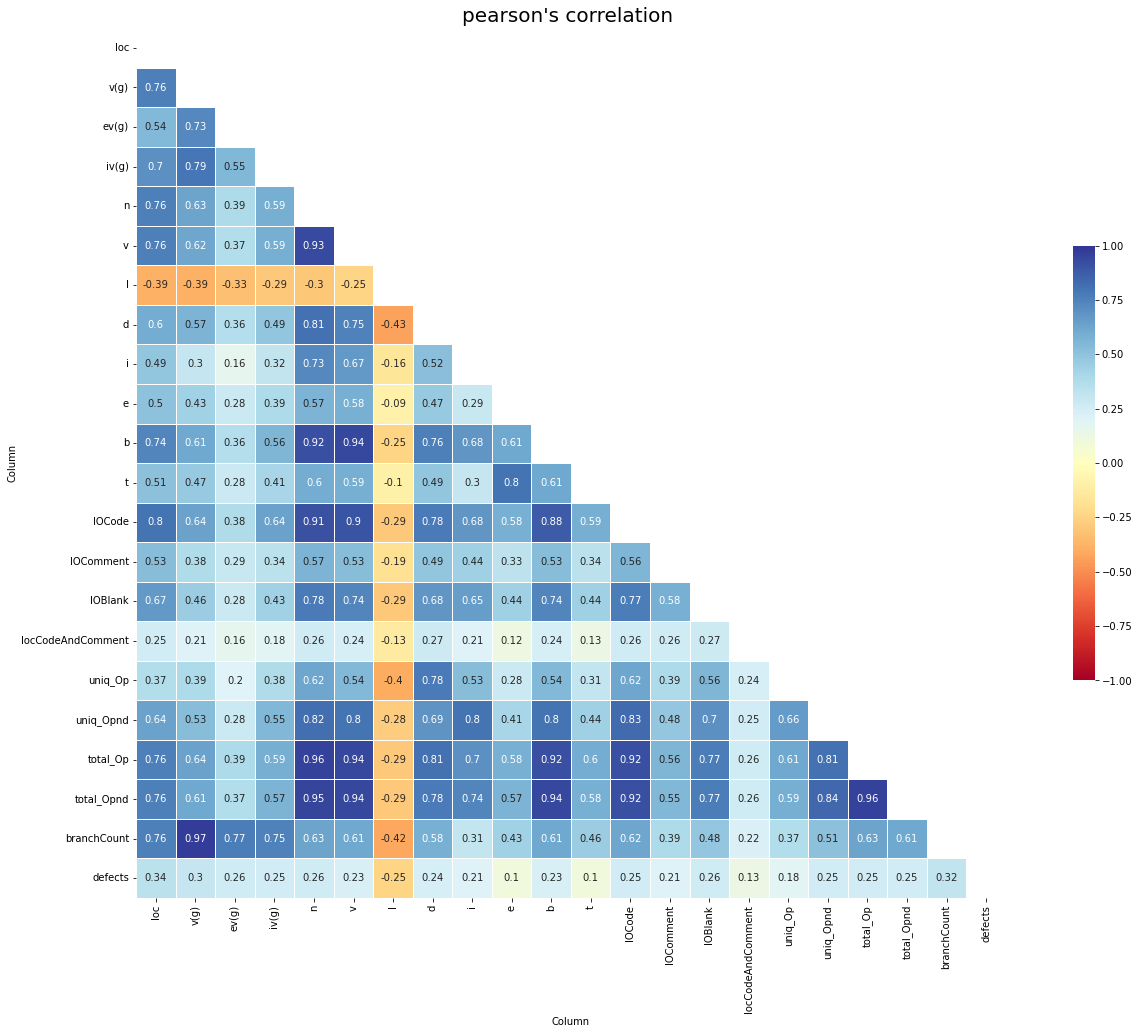

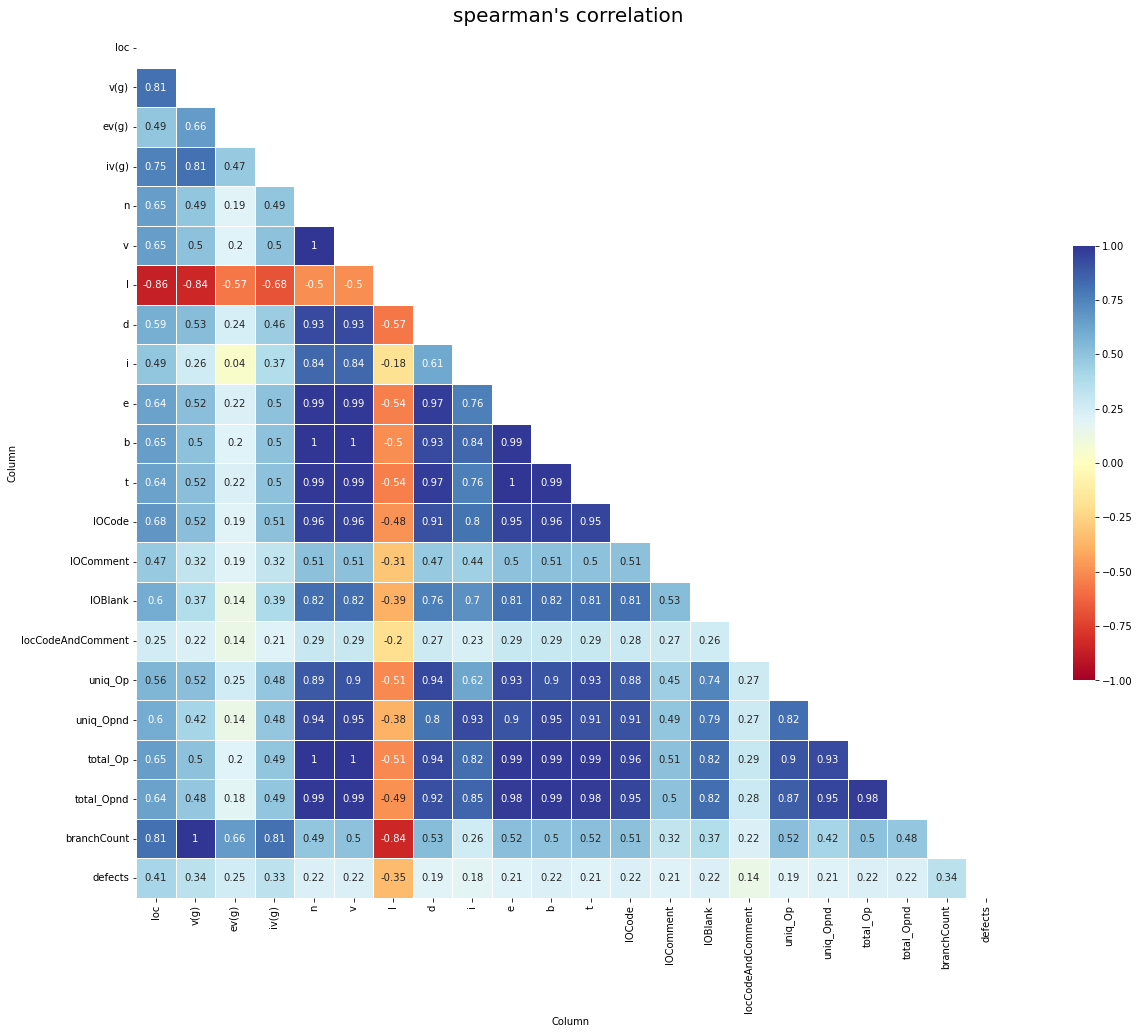

In [9]:
plt.figure(figsize=(24, 16))
triangle_heatmap(train_df.corr().round(2))
plt.title("pearson's correlation ", fontsize=20)
plt.show()

plt.figure(figsize=(24, 16))
triangle_heatmap(train_df.corr(method='spearman').round(2))
plt.title("spearman's correlation ", fontsize=20)
plt.show()

locCodeAndComment 는 (lOCode + lOComment 추정되지만 값을 보면 그렇지 않음)
또한 (약 92% 값이 0 이므로 버리는 것을 추천)

In [10]:
print(dict(train_df['locCodeAndComment'].value_counts()))
print('[0 비율]:', round(93550/train_df.shape[0], 3) * 100, '%')
train_df[['lOCode', 'lOComment', 'locCodeAndComment']]

{0: 93550, 1: 4221, 2: 1632, 3: 843, 4: 507, 5: 250, 6: 235, 7: 133, 8: 116, 10: 63, 11: 55, 9: 54, 12: 28, 13: 23, 14: 13, 24: 7, 15: 7, 20: 4, 28: 3, 23: 3, 38: 3, 22: 3, 16: 2, 18: 2, 17: 2, 43: 1, 19: 1, 26: 1, 32: 1}
[0 비율]: 91.9 %


Column,lOCode,lOComment,locCodeAndComment
id,,,
0,17,1,0
1,11,0,0
2,8,0,0
3,4,0,0
4,7,0,0
...,...,...,...
101758,7,0,0
101759,23,0,0
101760,20,0,0


In [11]:
# drop_columns = ['n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'locCodeAndComment']
drop_columns = ['n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'locCodeAndComment', 'total_Op', 'total_Opnd', 'branchCount']
train_drop = train_df.drop(columns=drop_columns)
test_drop = test_df.drop(columns=drop_columns)

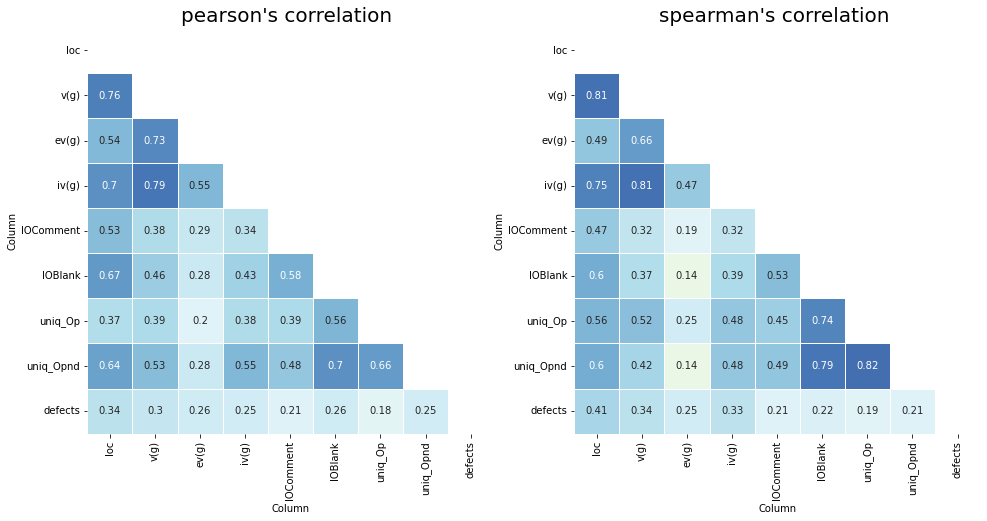

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
triangle_heatmap(train_drop.corr().round(2), ax=ax1, cbar=False)
triangle_heatmap(train_drop.corr(method='spearman').round(2), ax=ax2, cbar=False)
ax1.set_title("pearson's correlation ", fontsize=20)
ax2.set_title("spearman's correlation ", fontsize=20)
plt.show()

##### McCabe's

In [13]:
columns = ['loc', 'v(g)', 'ev(g)', 'iv(g)']
train = train_df[columns]
test = test_df[columns]

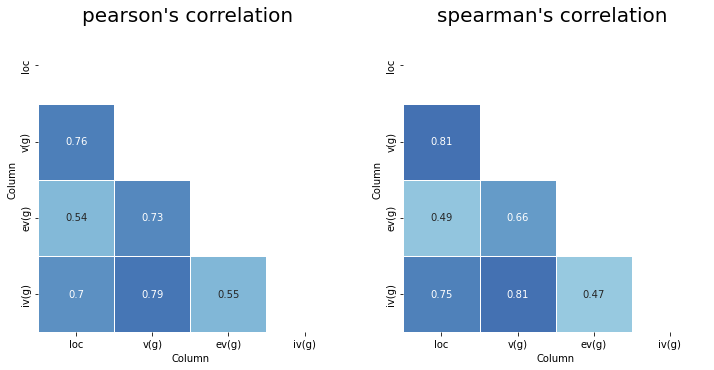

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
triangle_heatmap(train.corr().round(2), ax=ax1, cbar=False)
triangle_heatmap(train.corr(method='spearman').round(2), ax=ax2, cbar=False)
ax1.set_title("pearson's correlation ", fontsize=20)
ax2.set_title("spearman's correlation ", fontsize=20)
plt.show()